<a href="https://colab.research.google.com/github/PavelStelmakhV/hw310-keras-fasion-mnist/blob/main/keras_fasion_mnist_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11587792704621995568
xla_global_id: -1
]


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tf_keras

from keras import layers
from keras import models
from keras import regularizers
from keras import callbacks
from keras import initializers
from keras.layers import BatchNormalization
from keras.models import load_model
from tensorflow.keras.utils import to_categorical

In [3]:
num_classes = 10

In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [5]:
def drow_hist(data):
  plt.figure(figsize=(8,6), dpi= 80)
  _ = plt.hist(data,
              bins=num_classes,
              stacked=True,
              density=False,
              range=(0,10),
              rwidth=0.9,
              )

In [6]:
# create validation data
val_size =6000

x_val = x_train[-val_size:, :, :]
x_train = x_train[:-val_size, :, :]

y_val = y_train[-val_size:]
y_train = y_train[:-val_size]

In [7]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_val = x_val.astype('float32') / 255

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [8]:
w_init_tanh = initializers.glorot_normal(seed=111)
w_init_relu = initializers.HeNormal(seed=66)
# w_init_relu = initializers.HeUniform(seed=24)
b_init = initializers.Zeros()

In [9]:
def layer_relu(model, neurons, drop_out):
  model.add(BatchNormalization())
  model.add(layers.Dense(neurons,
                        activation='relu',
                        kernel_initializer=w_init_relu,
                        bias_initializer=b_init,
                        kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3),
                        bias_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3),
                        activity_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3)
                         )
  )
  model.add(layers.Dropout(drop_out))
  print(drop_out)
  return model

In [10]:
def layer_tanh(model, neurons, drop_out):
  model.add(BatchNormalization())
  model.add(layers.Dense(neurons,
                        activation='tanh',
                        kernel_initializer=w_init_tanh,
                        bias_initializer=b_init
                         )
  )
  model.add(layers.Dropout(drop_out))
  return model

In [11]:
model = models.Sequential()

neurons = 256
drop_out = 0.35

model.add(layers.Flatten(input_shape=(28, 28)))
model.add(layers.Dropout(0.13))

model = layer_relu(model, neurons*1, 0.3)
model = layer_relu(model, neurons*2, 0.35)
model = layer_relu(model, neurons*2, 0.4)
# model = layer_relu(model, neurons*2)


model.add(layers.Dense(10, activation='softmax'))

0.3
0.35
0.4


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [12]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.0004,
                                      beta_1=0.9,
                                      beta_2=0.999,
                                      epsilon=1e-06
)
# optimizer = tf.keras.optimizers.experimental.RMSprop(learning_rate=0.0005,
#                                                     rho=0.5,
#                                                     momentum=-16,
#                                                     epsilon=1e-07,
#                                                     centered=False,
#                                                     weight_decay=None,
#                                                     clipnorm=None,
#                                                     clipvalue=None,
#                                                     global_clipnorm=None,
#                                                     use_ema=False,
#                                                     ema_momentum=0.99,
#                                                     ema_overwrite_frequency=100,
#                                                     jit_compile=True,
#                                                     name='RMSprop',
# )

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [13]:
model.compile(#optimizer='adam',
              # optimizer='adamax',
              optimizer=optimizer,
              # optimizer='rmsprop',
              # optimizer='sgd',
              # optimizer='adadelta',
              # loss='binary_crossentropy',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy']) # sparse_categorical_accuracy

In [14]:
# callback = callbacks.EarlyStopping(monitor='val_loss',
#                                    patience=15,
#                                    restore_best_weights=True,
#                                    )
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=60)
mc = callbacks.ModelCheckpoint('best_model.h5', monitor='categorical_accuracy', mode='max', verbose=0, save_best_only=True)


In [15]:
history = model.fit(x_train, y_train,
                    epochs=300,
                    batch_size=128,
                    # callbacks=[callback],
                    callbacks=[mc, es],
                    verbose=1, #многословие
                    # validation_split=0.2
                    validation_data=(x_val, y_val)
                    )
test_loss, test_acc = model.evaluate(x_test, y_test)
print('\nTest accuracy:', test_acc)

Epoch 1/300
422/422 [==============================] - 31s 55ms/step - loss: 24.1222 - categorical_accuracy: 0.6988 - val_loss: 12.3783 - val_categorical_accuracy: 0.7708
Epoch 2/300
  3/422 [..............................] - ETA: 10s - loss: 12.3609 - categorical_accuracy: 0.8073

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


422/422 [==============================] - 12s 29ms/step - loss: 6.4153 - categorical_accuracy: 0.8077 - val_loss: 3.0194 - val_categorical_accuracy: 0.8207
Epoch 3/300
422/422 [==============================] - 13s 30ms/step - loss: 1.8668 - categorical_accuracy: 0.8134 - val_loss: 1.4742 - val_categorical_accuracy: 0.8283
Epoch 4/300
422/422 [==============================] - 12s 29ms/step - loss: 1.4207 - categorical_accuracy: 0.8111 - val_loss: 1.3008 - val_categorical_accuracy: 0.8263
Epoch 5/300
422/422 [==============================] - 12s 29ms/step - loss: 1.3329 - categorical_accuracy: 0.8142 - val_loss: 1.1939 - val_categorical_accuracy: 0.8470
Epoch 6/300
422/422 [==============================] - 12s 29ms/step - loss: 1.2724 - categorical_accuracy: 0.8194 - val_loss: 1.1622 - val_categorical_accuracy: 0.8432
Epoch 7/300
422/422 [==============================] - 12s 29ms/step - loss: 1.2384 - categorical_accuracy: 0.8189 - val_loss: 1.1392 - val_categorical_accuracy: 0.844

In [16]:
print('\nhistory dict:', list(history.history.keys()))


history dict: ['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy']


In [17]:
result = model.evaluate(x_test, y_test)
print(result)

313/313 [==============================] - 1s 4ms/step - loss: 0.7428 - categorical_accuracy: 0.8483
[0.7428407669067383, 0.8482999801635742]


In [18]:
saved_model = load_model('best_model.h5')
result = saved_model.evaluate(x_test, y_test)
print(result)

313/313 [==============================] - 2s 4ms/step - loss: 0.7154 - categorical_accuracy: 0.8583
[0.7154227495193481, 0.858299970626831]


In [19]:
# from keras.models import load_model
# saved_model = load_model('best_model.h5')
# # _, train_acc = saved_model.evaluate(x_train, y_train, verbose=0)
# _, test_acc = saved_model.evaluate(x_test, y_test, verbose=0)
# print('Test: %.3f' % (test_acc))

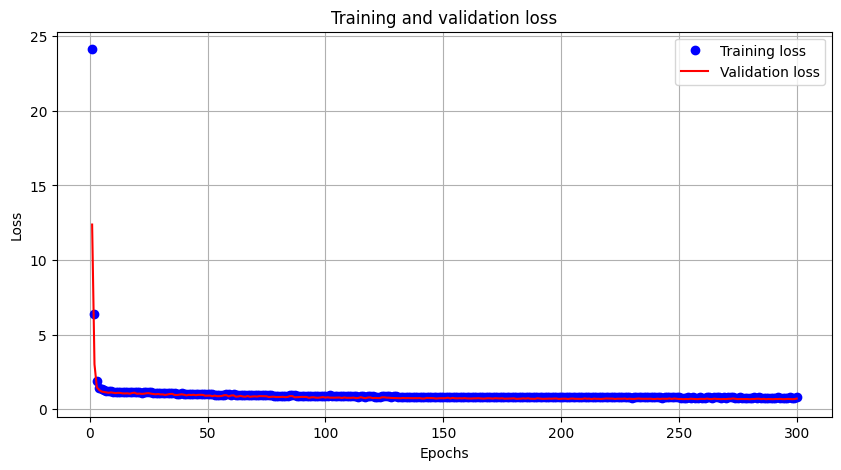

<Figure size 640x480 with 0 Axes>

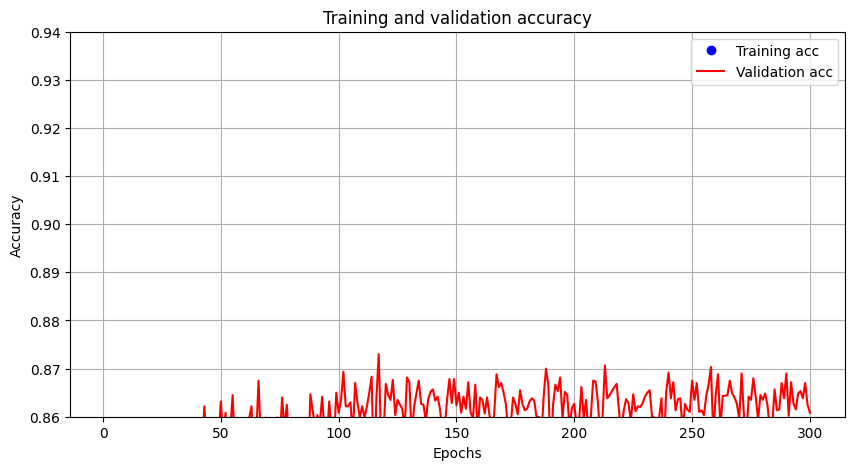

In [20]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['loss']) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
# plt.ylim (0.2, 0.5)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
1
plt.clf()
plt.figure(figsize=(10, 5))
val_acc_values = history_dict['categorical_accuracy']
plt.plot(epochs, history_dict['categorical_accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_categorical_accuracy'], 'r', label='Validation acc')
plt.ylim (0.86, 0.94)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

In [21]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

In [22]:
predictions = probability_model.predict(x_test)

313/313 [==============================] - 2s 5ms/step


In [23]:
predictions[0]

array([0.08610022, 0.08609761, 0.08609781, 0.08609909, 0.08609843,
       0.08759163, 0.08609927, 0.09018335, 0.08613569, 0.21949688],
      dtype=float32)

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dropout (Dropout)           (None, 784)               0         
                                                                 
 batch_normalization (Batch  (None, 784)               3136      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                       